# Project 2 Stochastic Modeling
# Movement of Ants
# Elizabeth Dautel and Brandt Bessell

### Ants.ipynb - iPython file for Module 10.4, "Movement of Ants – Taking the Right Steps"
Introduction to Computational Science:  Modeling and Simulation for the Sciences, 2nd Edition
Angela B. Shiflet and George W. Shiflet
Wofford College
© 2014 by Princeton University Press

# Introduction
### Most species of ants portray their movements to other ants in the colony when carrying food by excreting a chemical pheromone. In the model ants are simulated to represent the role of pheromones in ant movement, the ants will find the highest concentration of pheromone and follow it along a path to find the food source. The chemical trail evaporates over time as the ant travels further from the source. The ant model simulates global behavior within the inidivuals in the ant colony, over time all of the individuals will tend towards the pheromone trail. 

# Model Parameters
| Parameters    | Value    | Description                                                                                      |   |   |
|---------------|----------|--------------------------------------------------------------------------------------------------|---|---|
| EMPTY         | 0        | Empty ground containing no ant                                                                   |   |   |
| NORTH         | 1        | Ant about to move to or just moved from the north                                                |   |   |
| EAST          | 2        | Ant about to move to or just moved from the east                                                 |   |   |
| SOUTH         | 3        | Ant about to move to or just moved from the south                                                |   |   |
| WEST          | 4        | Ant about to move to or just moved from the west                                                 |   |   |
| STAY          | 5        | Ant about to stay in or did not move from the current site                                       |   |   |
| BORDER        | 6        | Border                                                                                           |   |   |
| EVAPORATE     | variable | For a cell that remains empty, the amount of chemical decrements by a constant amount  |   |   |
| THRESHOLD     | variable | The amount of pheromone in a cell which dictates the deposit of more pheromone                   |   |   |
| DEPOSIT       | variable | The amount of pheromone deposited into the cell after an ant has visited the cell                |   |   |
| probAnt       | variable | The probability that an ant initially occupies a cell                                            |   |   |
| diffusionRate | variable | Rate as which pheromone is deposited                                                             |   |   |
|               |          |                                                                                                  |   |   |



1. An empty cell does not point toward any direction. 
2. An ant does not turn to a cell from which the creature just came. 
3. An ant does not turn to a location that is a border site. 
4. An ant does not turn to a location that currently contains an ant. 
5. Otherwise, an ant turns in the direction of the neighboring available (not the previous, an occupied, or a border cell) with the greatest amount of chemical. In the case of more than one neighbor having the maximum amount, the ant turns at random towards one of these cells.
6. If no neighboring cell is available, the ant will not move
7. For a cell that remains empty, the amount of chemical decrements by a constant amount, EVAPORATE, but does not fall below 0. Thus, the new amount is the maximum of 0 and the current amount minus EVAPORATE.
8. An ant facing in a certain direction will move into that neighboring cell as long as no other ant has already moved there. 
9. Otherwise, the ant will stay in its current cell. 
10.  If an ant leaves a cell that has pheromone above a certain threshold, THRESHOLD, the amount of chemical increments by a set amount, DEPOSIT, to reinforce the trail.
11. If an ant stays in a cell, the amount of chemical remains the same. 
12.  After moving to a new location, the ant faces towards the cell from which the animal just came. 

# Model Development
### A trail of pheromone is present in the simulation initially and additional chemical pheromone can be excreted by individual ants to rienforce the existing trail. The pheromone dissipates over time depending on the given dissipation rate. The model does not include the ant carrying food. The ants are assumed to be contained in a square enclosed by glass. The ants are assumed to neever turn around completely in one time step, in other words the ant will never return back from a location is just traveled from. If the ant is unable to move to a square with a higher concentration of pheromone due to a neighboring ant, it will stay in place for one time step or until another space is available to prevent collision. When an ant moves from one site to a neighboring site, it will deposit a certain amount of chemical pheromone which will dissipate as the ant moves away from the new site. In this model, the initial trail of pheromone is straight and increases from left to right.

In [39]:
%matplotlib inline

In [40]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML  # for embedded matplotlib animation
from math import *
from random import *
from copy import deepcopy

matplotlib.rc('animation', html='html5')

## constants
2 grids that are already extended
	pherGrid - level of chemical attractant is a nonnegative integer, 0 elsewhere, -0.01 on border
    
	antGrid - grid indicating ants and directions in which they face 
    
		EMPTY = 0- empty site
		NORTH = 1- N-facing ant
		EAST = 2 - E-facing ant
		SOUTH = 3 - S-facing ant
		WEST = 4 - W-facing ant
		STAY = 5 - ant to stay in current location
		BORDER = 6 - on border
        
probAnt = probability of cell being occupied

THRESHOLD - threshold value for ant to deposit additional pheromone

In [41]:
global EMPTY, NORTH, EAST, SOUTH, WEST, STAY, BORDER, MAXPHER, EVAPORATE, DEPOSIT, THRESHOLD

EMPTY= 0
NORTH =1
EAST = 2
SOUTH = 3
WEST = 4
STAY=5
BORDER=6
MAXPHER = 50.0 
EVAPORATE = 1
DEPOSIT = 2
THRESHOLD = 0.1

## Initialize antGrid with random ants

In [42]:
def initAntGrid(n, probAnt):
    grid = BORDER*np.ones((n+2, n+2)) #n=size or number of rows and columns
    for i in range(1, n+1): #i=column
        for j in range(1, n+1): #j=row
            if random() < probAnt:
                grid[i, j] = randint(0, 3)
            else:
                grid[i, j] = EMPTY
    return grid

## Initialize pheromonGrid with a trail that becomes increasingly stronger as the column number increases(left to right).  Have absorbing boundary conditions.

In [43]:
def initPherGrid(n):
    grid = np.zeros((n+2, n+2))
    
    # border of -0.01
    for i in range(0, n+2):
        grid[i, 0] = -0.01
        grid[i, n+1] = -0.01
    for j in range(1, n+1):
        grid[0, j] = -0.01
        grid[n+1, j] = -0.01
        
  #change number of initial chemical cells   *************   
    mid = int(n/2)
    for i in range(1, n+1):
        grid[mid, i] = MAXPHER * i / n
    return grid

## Function to return the new pheromone value in a cell by diffusion 

In [44]:
def diffusionPher(diffusionRate, site, N, NE, E, SE, S, SW, W, NW):
    return (1 - 8*diffusionRate)*site + diffusionRate*(N + NE + E + SE + S + SW + W + NW)

## Function to take an extended pheromone grid and to return a new grid, also extended with diffused pheromone

In [45]:
def applyDiffusionExtended(matExt, diffusionRate):
    n = matExt.shape[1] - 2
    pherGrid = deepcopy(matExt)    
    
    for i in range(1, n + 1):
        for j in range(1, n + 1):
            site = matExt[i, j]
            N = matExt[i - 1, j]
            NE = matExt[i - 1, j + 1]
            E = matExt[i, j + 1]
            SE = matExt[i + 1, j + 1]
            S = matExt[i + 1, j]
            SW = matExt[i + 1, j - 1]
            W = matExt[i, j - 1]
            NW = matExt[i - 1, j - 1]
            pherGrid[i, j] = diffusionPher(diffusionRate, site, N, 
                                           NE, E, SE, S, SW, W, NW)
    return pherGrid

## Function to return a list of indices where mx occurs in list lst

In [46]:
def find(lst, mx):
    return [idx for idx, val in enumerate(lst) if val == mx]

## Function to apply sensing rules to orient ant
Empty site remains unchanged

Ant turns to highest scent in N, E, S, W direction; at random to equal maximum locations

In [47]:
def sense(site, na, ea, sa, wa, np, ep, sp, wp):
    if (site == EMPTY):
        direction = EMPTY
        return direction
    
    lst = [np, ep, sp, wp]
    # don't allow ant to turn to previous cell, so make value artificially 
    # small
    if (site < STAY):
        # - 1 to match Python indexing
        lst[int(site) - 1] = -2
        
    # don't allow ant to turn to cell with another ant, so make value
    # artificially small
    neighbors = [na, ea, sa, wa]
    
    for i in range(4):
        if (neighbors[i] > 0):
            lst[i] = -2

    mx = max(lst)
    if (mx < 0):
        direction = STAY
    else:
        posList = find(lst, mx)
        lng = len(posList)
        rndPos = randint(0, lng - 1)        
        direction = posList[rndPos] + 1 # add 1 for proper direction
        
    return direction

## Function to apply sense function to every interior cell of extended grid

In [48]:
def applySenseExtended(antGrid, pherGrid):
    n = len(antGrid) - 2
    newAntGrid = deepcopy(antGrid) 
    for i in range(1, n + 1):
        for j in range(1, n + 1):
            if (antGrid[i, j] != EMPTY):
                site = antGrid[i, j]
                Nant = antGrid[i-1, j]
                Eant = antGrid[i, j+1]
                Sant = antGrid[i+1, j]
                Want = antGrid[i, j-1]
                Npher = pherGrid[i-1, j]
                Epher = pherGrid[i, j+1]
                Spher = pherGrid[i+1, j]
                Wpher = pherGrid[i, j-1]
                newAntGrid[i, j] = sense(site, Nant, Eant, Sant, Want, 
                                         Npher, Epher, Spher, Wpher)

    return newAntGrid

## Rules for movement of ant - walk function:
If no ant, decrease strength of scent by 1, but not lower than 0.
Have the ant to face in the direction from wince it came so that in sense function it is possible to eliminate the ant immediately returning there.

In [49]:
def walk(antGrid, pherGrid):
    n = len(antGrid) - 2
    newAntGrid = deepcopy(antGrid)
    newPherGrid = deepcopy(pherGrid)
    for i in range(1, n + 1):
        for j in range(1, n + 1):
            if(antGrid[i, j] == EMPTY):
                newPherGrid[i, j] = max(newPherGrid[i, j] - EVAPORATE, 0)
        
            # else if can move in desired direction (no ant there now and no ant 
            # already planning to go there at the next time step), increment 
            # pheromone in site, make site empty, and change value in desired site
            # to have ant and to point in the direction from where it came
            if(antGrid[i, j] == NORTH): 
                if(newAntGrid[i-1, j] == EMPTY): # can move 
                    if(newPherGrid[i, j] > THRESHOLD):
                        newPherGrid[i, j] = newPherGrid[i, j] + DEPOSIT

                    newAntGrid[i, j] = EMPTY
                    newAntGrid[i-1, j] = SOUTH
                else:
                    newAntGrid[i, j] = STAY # can't move 

            if(antGrid[i, j] == EAST):
                if(newAntGrid[i, j+1] == EMPTY): # can move 
                    if(newPherGrid[i, j] > THRESHOLD):
                        newPherGrid[i, j] = newPherGrid[i, j] + DEPOSIT

                    newAntGrid[i, j] = EMPTY
                    newAntGrid[i, j+1] = WEST
                else:
                    newAntGrid[i, j] = STAY # can't move 

            if(antGrid[i, j] == SOUTH): # can move 
                if(newAntGrid[i+1, j] == EMPTY):
                    if(newPherGrid[i, j] > THRESHOLD):
                        newPherGrid[i, j] = newPherGrid[i, j] + DEPOSIT

                    newAntGrid[i, j] = EMPTY
                    newAntGrid[i+1, j] = NORTH
                else:
                    newAntGrid[i, j] = STAY # can't move

            if(antGrid[i, j] == WEST): # can move 
                if(newAntGrid[i, j-1] == EMPTY):
                    if(newPherGrid[i, j] > THRESHOLD):
                        newPherGrid[i, j] = newPherGrid[i, j] + DEPOSIT
                    newAntGrid[i, j] = EMPTY
                    newAntGrid[i, j-1] = EAST
                else:
                    newAntGrid[i, j] = STAY # can't move 
    
    return newAntGrid, newPherGrid

## Ants simulation

In [50]:
def ants(n, probAnt, diffusionRate, t):
    meanlst = []
    anttot = 0
    antGrid = initAntGrid(n, probAnt)
    pherGrid = initPherGrid(n)
    antGrids = np.zeros((n+2, n+2, t+1))
    antGrids[:, :, 0] = deepcopy(antGrid)
    pherGrids = np.zeros((n+2, n+2, t+1))
    pherGrids[:, :, 0] = deepcopy(pherGrid)
    x = antGrids[0,:,0].size
    y = antGrids[:,0,0].size
    for tidx in range(t):
        meancnt=0
        antGrid = applySenseExtended(antGrid, pherGrid)
        antGrid, pherGrid = walk(antGrid, pherGrid)
        pherGrid = applyDiffusionExtended(pherGrid, diffusionRate)
        antGrids[:, :, tidx+1] = deepcopy(antGrid)
        pherGrids[:, :, tidx+1] = deepcopy(pherGrid)
        for i in range(x):
            for j in range(y):
                if antGrids[i,j,tidx] > 0 and antGrids[i,j,tidx] < 6:
                    if tidx==1:
                        anttot+=1
                    if pherGrids[i-2:i+2,j-2:j+2,tidx].any() > 0.1:
                        meancnt+=1
            meanlst.append(meancnt)
    return antGrids, pherGrids, meanlst, anttot

## Function to display a list of grids
Show ant as red color with degree of color depending on amount of chemical in cell; show empty cell with shade of gray

In [51]:
def makeColorGridFloat(antGrid, pherGrid):
    n = len(antGrid) - 2
    colorGrid = np.zeros((n+2, n+2, 3))
    firstEls = 1 - deepcopy(pherGrid)/MAXPHER
    colorGrid[:, :, 0] = firstEls
    colorGrid[:, :, 1] = firstEls
    colorGrid[:, :, 2] = firstEls
    for i in range(0, n+2):
        for j in range(0, n+2):
            if (antGrid[i, j] == 6):
                colorGrid[i, j, 0] = 0
                colorGrid[i, j, 1] = 0
                colorGrid[i, j, 2] = 1
            elif (antGrid[i, j] > 0):
                colorGrid[i, j, 0] = 1
                colorGrid[i, j, 1] = 0
                colorGrid[i, j, 2] = 0

    return (colorGrid*255).astype(np.uint8)

## Run Program
After each simulation, display animation of grids with code below.

### Perform simulation

In [52]:
seed(1)
n = 30
probAnt = 0.08
diffusionRate = 0.01
t = 50
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
np.mean(meanlst)

17.663125

# Part C
### Displays the effect that varying probability of spawning ant in a cell has on the mean number of ants that are within two units of the chemical pheromone


In [53]:
table1 = ['probAnt','mean']
for trial in range(10):    
    probAnt = 0.06
    trialmeans = []
    for idx in range(5):
        antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
        thismean = np.mean(meanlst)
        trialmeans.append(thismean)
        if trial == 9:
            meanofmeans = np.mean(trialmeans)
            table1 = np.vstack((table1,['%.2f'%probAnt,'%.2f'%meanofmeans]))
        probAnt += 0.02
for line in table1:
    print(*line)


probAnt mean
0.06 13.22
0.08 16.58
0.10 19.74
0.12 22.89
0.14 25.91


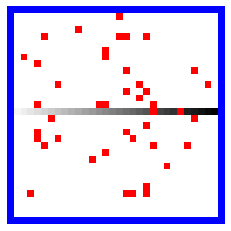

In [54]:
probAnt = 0.06
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

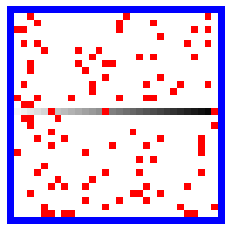

In [55]:
probAnt = 0.14
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)

# The animation function: called to produce a frame for each generation.
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,

grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)

# To save the animation, use the command, placed before HTML: 
grid_ani.save('AntsColor.mp4', writer=writer)

HTML(grid_ani.to_html5_video())

### As the probability of an ant present increases the mean number of ants within two cells of a chemical increases. An animated comparison of the low probAnt=0.06 and high probAnt=0.14 is displayed above. 

### Effect of varying simulated grid size of spawning ant in a cell

In [56]:
probAnt = 0.08
table2 = ['n','mean']
for trial in range(10):
    n = 10    
    trialmeans = []
    for idx in range(5):
        antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
        thismean = np.mean(meanlst)
        trialmeans.append(thismean)
        if trial == 9:
            meanofmeans = np.mean(trialmeans)
            table2 = np.vstack((table2,[n,'%.2f'%meanofmeans]))
        n += 10
for line in table2:
    print(*line)


n mean
10 4.16
20 8.05
30 10.20
40 14.36
50 18.02


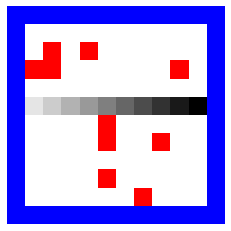

In [57]:
n = 10
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

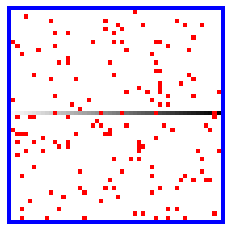

In [58]:
n = 50
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

### The cell size has an effect on the number of ants observed in the simulation. A larger grid size allows the user to better visualize trends in the ants movement. The two extreme values were animated above with the grid size equal to 10 and 50. The mean number of ants within two units of a cell with pheromone present increases as the cell size increases.

### Effect of varying diffusion rate

In [59]:
n = 30
table3 = ['drate','mean']
for trial in range(10):
    diffusionRate = 0.01   
    trialmeans = []
    for idx in range(10):
        antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
        thismean = np.mean(meanlst)
        trialmeans.append(thismean)
        if trial == 9:
            meanofmeans = np.mean(trialmeans)
            table3 = np.vstack((table3,['%.2f'%diffusionRate,'%.2f'%meanofmeans]))
        diffusionRate += 0.01
for line in table3:
    print(*line)

drate mean
0.01 18.67
0.02 19.58
0.03 21.20
0.04 19.40
0.05 19.61
0.06 20.09
0.07 20.30
0.08 19.93
0.09 19.53
0.10 20.27


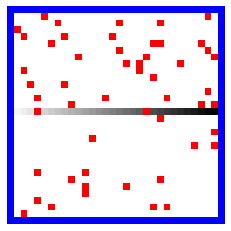

In [60]:
diffusionRate = 0.01
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

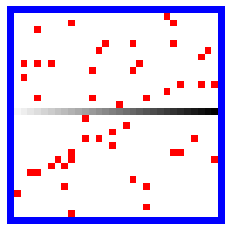

In [61]:
diffusionRate = 0.10
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

### The diffusion rate controls the speed at which the chemical pheromone dissipates from the cell the ant recently moved away from. The two extreme diffusion rates are animated above with a diffusion rate of 0.01 and of 0.10. The chemical pheromone, shown in grey, dissapears from the simulation quickly when the dissipation rate is set to 0.10 as compared to a rate at 0.01. The increasing diffusion rate has a small effect on the mean number of ants within two cells of the chemical pheromone.

### Effect of varying maximum pheromone value

In [62]:
diffusionRate = 0.01
table4 = ['maxpher','mean']
for trial in range(10):
    MAXPHER = 10.0
    trialmeans = []
    for idx in range(8):
        antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
        thismean = np.mean(meanlst)
        trialmeans.append(thismean)
        if trial == 9:
            meanofmeans = np.mean(trialmeans)
            table4 = np.vstack((table4,[MAXPHER,'%.2f'%meanofmeans]))
        MAXPHER += 10.0
for line in table4:
    print(*line)

maxpher mean
10.0 23.23
20.0 18.86
30.0 21.53
40.0 19.55
50.0 19.43
60.0 20.34
70.0 20.05
80.0 20.71


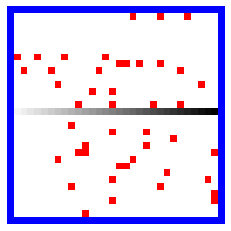

In [63]:
MAXPHER = 10.0
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

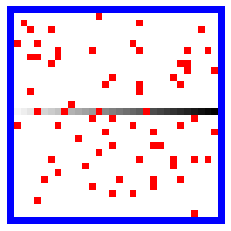

In [64]:
MAXPHER = 80.0
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

### The maximum pheromone value determines the maximum amount of pheromone that can be present in a cell at a given time step. As the maximum pheromone value increases, the mean number of ants within two cells of the pheromone decreases. The animations above simulate the max pheromone value at 10 and at 80.

### Effect of varying evaporation rate

In [65]:
MAXPHER = 50.0
table5 = ['evap','mean']
for trial in range(10):
    EVAPORATE = 0.5
    trialmeans = []
    for idx in range(6):
        antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
        thismean = np.mean(meanlst)
        trialmeans.append(thismean)
        if trial == 9:
            meanofmeans = np.mean(trialmeans)
            table5 = np.vstack((table5,[EVAPORATE,'%.2f'%meanofmeans]))
        EVAPORATE += 0.5
for line in table5:
    print(*line)

evap mean
0.5 15.75
1.0 16.46
1.5 17.54
2.0 18.49
2.5 19.16
3.0 18.92


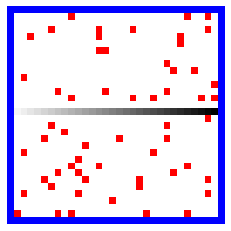

In [66]:
EVAPORATE = 0.5
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

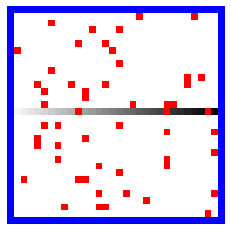

In [67]:
EVAPORATE = 3.0
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

### The evaporation rate is determined as the pheromone dissipation rate when a cell remains empty of an ant. As the evaporation rate increases, pheromone in the cell decreases mpre quickly. The mean number of ants within two cells of a pheromone increases as the evaporation rate increases. The two extreme values for evaporation rate are animated above, with evaporation rate equal to 0.5 and 3. 

### Effect of varying deposit value

In [68]:
EVAPORATE = 1.0
table6 = ['deposit','mean']
for trial in range(10):
    DEPOSIT = 0.5 
    trialmeans = []
    for idx in range(6):
        antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
        thismean = np.mean(meanlst)
        trialmeans.append(thismean)
        if trial == 9:
            meanofmeans = np.mean(trialmeans)
            table6 = np.vstack((table6,[DEPOSIT,'%.2f'%meanofmeans]))
        DEPOSIT += 0.5
for line in table6:
    print(*line)


deposit mean
0.5 12.13
1.0 13.06
1.5 15.34
2.0 16.61
2.5 17.60
3.0 18.05


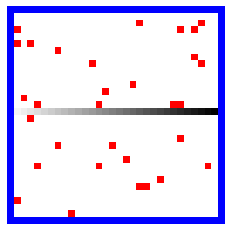

In [69]:
DEPOSIT = 0.5
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

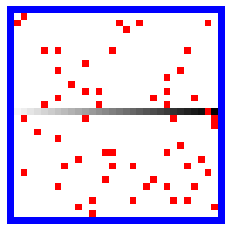

In [70]:
DEPOSIT = 3.0
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

### The amount of pheromone an ant deposits in a cell after visting the cell is determined by the value of deposit. As the amount of pheromone deposited increases the mean number of ants within two cells of the pheromone also increases. The two extreme values for pheromone deposited are animated above with the deposit equal to 0.5 and 3.

### Effect of varying threshold value

In [71]:
DEPOSIT = 1.0
table7 = ['threshold','mean']
for trial in range(10):
    THRESHOLD = 0.0
    trialmeans = []
    for idx in range(11):
        antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
        thismean = np.mean(meanlst)
        trialmeans.append(thismean)
        if trial == 9:
            meanofmeans = np.mean(trialmeans)
            table7 = np.vstack((table7,[THRESHOLD,'%.2f'%meanofmeans]))
        THRESHOLD += 0.2
for line in table7:
    print(*line)


threshold mean
0.0 23.40
0.2 18.69
0.4 20.64
0.6000000000000001 19.56
0.8 20.16
1.0 20.72
1.2 19.60
1.4 19.66
1.5999999999999999 20.40
1.7999999999999998 20.60
1.9999999999999998 20.38


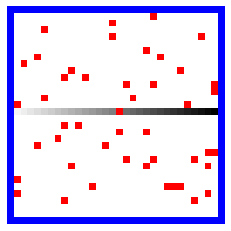

In [72]:
THRESHOLD = 0
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

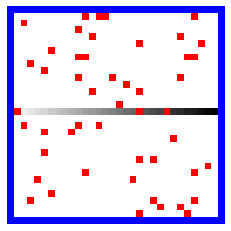

In [73]:
THRESHOLD = 0.2
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())

### If an ant leaves a cell that has pheromone above a certain threshold the amount of chemical increments by a set amount to reinforce the trail. As the threshold increases the mean number of ants within two units of the chemical shows a decreasing trend. 

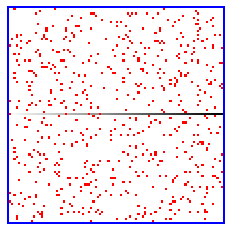

In [74]:
THRESHOLD = 0.1
EVAPORATE = 0.5
DEPOSIT = 1.0
n = 100
probAnt = 0.08
diffusionRate = 0.05
t = 1000
antGrids, pherGrids, meanlst, anttot = ants(n, probAnt, diffusionRate, t)
Writer = animation.writers['ffmpeg'];
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
plt.axis('off')
im = plt.imshow(makeColorGridFloat(antGrids[:,:,0], pherGrids[:,:,0]), animated=True)
def updatefig(i, *args):
    global antGrids, pherGrids
    im.set_array(makeColorGridFloat(antGrids[:,:,i], pherGrids[:,:,i]))
    return im,
grid_ani = animation.FuncAnimation(fig, updatefig, 
                                   save_count = antGrids.shape[2], 
                                   interval=50, blit=False)
grid_ani.save('AntsColor.mp4', writer=writer)
HTML(grid_ani.to_html5_video())
# %